In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
import math
from sklearn.preprocessing import normalize
import pylab
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

def genData(mu, sigma, n, d):
    
    for i in range(n):
    
        x = np.random.normal(mu, sigma, size=d).reshape(1,d)
        if i%math.floor(n/100) == 0:
            print(i/math.floor(n/100))
        if i==0:
            temp=x
        else:
            temp = np.append(arr=X, values=x, axis=0)

        while np.std(temp) > sigma:
        
            x = np.random.normal(mu, sigma, size=d).reshape(1,d)
            if i==0:
                temp=x
            elif i>0:
                temp = np.append(arr=X, values=x, axis=0)

        x = x.reshape(1,d)
        if i == 0:
            X = x
        elif i>0:
            X = np.append(arr=X, values=x, axis=0)
        

    w = np.random.uniform(low=0.0, high=1.0, size=d).reshape(d,1)
    b = np.random.normal(0, 1, size=n).reshape(n)
    y = np.matmul(X, w).reshape(n) 
    return X,y



def l1norm_X_and_y_preserve_linearity(X, y, val):
    
    n = X.shape[0]
    d = X.shape[1]
    for i in range(n):
        row_abs_sum = sum(abs(X[i, :]))
        X[i] = X[i]/row_abs_sum
        if val == 1:
            y[i] = y[i]/row_abs_sum
        else:
            ymax = max(abs(y))
            y = y/ymax

    return X, y


def priv_plotter(X, y, n, d, k, epsilon, jump, rep, apply_u, apply_v):
    
    X = X[:n, :d]
    y = y[:n]
    
    elems = math.floor(((d+2)/2)*(d+1))
    split_val = math.floor(n/5)
    m = math.floor((n-split_val)/jump)
    
    X = np.append(arr=np.ones((n,1)), values=X, axis=1)
    
    # range of X and y is -1 to 1
    X, y = l1norm_X_and_y_preserve_linearity(X,y,0)
    

    RMSE = np.zeros((k, m))
    priv_RMSE = np.zeros((k, m))
    X_val = np.zeros((m))
    p_corr_rank = np.zeros((m))
    np_corr_rank = np.zeros((m))

    for i in range(k):
    
        X_test = X[i*split_val:(i+1)*split_val, :]
        y_test = y[i*split_val:(i+1)*split_val]
    
        X_without_XTest = X[:i*split_val, :]
        X_without_XTest = np.append(arr=X_without_XTest, values=X[(i+1)*split_val:, :], axis=0)
    
        y_without_yTest = y[:i*split_val]
        y_without_yTest = np.append(arr=y_without_yTest, values=y[(i+1)*split_val:], axis=0)
    
        for j in range(m):
            X_val[j] = math.floor((j+1)*jump)
            train_size = math.floor((j+1)*jump)
            X_train = X_without_XTest[:train_size, :]
            y_train = y_without_yTest[:train_size]
        
            xT = X_train.transpose()
            xTx = np.matmul(xT, X_train)
            xTx_pinv = np.linalg.pinv(xTx)
            xTy = np.matmul(xT, y_train)
            w = np.matmul(xTx_pinv, xTy)
        
            priv_RMSE_per_lpl = np.zeros((rep))
            
            T_per_rep = np.ones((y_test.shape[0],0))
            
            for l in range(rep):
                b1 = elems/(epsilon)
                b2 = d/epsilon
            
                u_mirr = np.random.laplace(loc=0.0, scale=b1, size = elems)
                
                pos = 0
                u = np.ones((d+1, d+1))
                for r in range(d+1):
                    for c in range(r, d+1):
                        u[c][r] = u_mirr[pos]
                        u[r][c] = u[c][r]
                        pos = pos+1
                v = np.random.laplace(loc=0.0, scale=b2, size = d+1)
            
                sTs = xTx 
                sTt = xTy 
                if apply_u == 1:
                    sTs = xTx + u
                if apply_v == 1:
                    sTt = xTy + v
                sTs_pinv = np.linalg.pinv(sTs)
                wi = np.matmul(sTs_pinv, sTt)
                T = np.matmul(X_test, wi)
                
                if l == 0:
                    T_per_rep = T.reshape(T.shape[0], 1)
                
                else:
                    T_per_rep = np.append(arr=T_per_rep, values=T.reshape(T.shape[0], 1), axis=1)
                
                priv_RMSE_per_lpl[l] = np.mean(abs(T-y_test)**2)**0.5

            T_avg = sum(T_per_rep.transpose())/rep
            
            corr, p_val = spearmanr(T_avg, y_test)
            p_corr_rank[j] = corr
            
            priv_RMSE[i][j] = np.mean(priv_RMSE_per_lpl)
            y_pred = np.matmul(X_test, w)
            corr, p_val = spearmanr(y_pred, y_test)
            np_corr_rank[j] = corr
            RMSE[i][j] = np.mean(abs(y_pred-y_test)**2)**0.5

    total_RMSE = sum(RMSE)/k
    priv_total_RMSE = sum(priv_RMSE)/k

    RMSE_SD = np.zeros((m))
    priv_RMSE_SD = np.zeros((m))
    for i in range(m):
        RMSE_SD[i] = RMSE[:, i:i+1].std()
        priv_RMSE_SD[i] = priv_RMSE[:, i:i+1].std()

    ans = np.zeros((7,m))
    ans[0] = X_val
    ans[1] = priv_total_RMSE
    ans[2] = priv_RMSE_SD
    ans[3] = total_RMSE
    ans[4] = RMSE_SD
    ans[5] = p_corr_rank
    ans[6] = np_corr_rank

    return ans


def np_plotter(X, y, n, d, k, jump):
    
    X = X[:n, :d]
    y = y[:n]
    
    rep = 10
    elems = math.floor(((d+2)/2)*(d+1))
    split_val = math.floor(n/5)
    m = math.floor((n-split_val)/jump)
    
    X = np.append(arr=np.ones((n,1)), values=X, axis=1)

    X, y = l1norm_X_and_y_preserve_linearity(X,y,0)

    RMSE = np.zeros((k, m))
    X_val = np.zeros((m))
    np_corr_rank = np.zeros((m))

    for i in range(k):
    
        X_test = X[i*split_val:(i+1)*split_val, :]
        y_test = y[i*split_val:(i+1)*split_val]
    
        X_without_XTest = X[:i*split_val, :]
        X_without_XTest = np.append(arr=X_without_XTest, values=X[(i+1)*split_val:, :], axis=0)
    
        y_without_yTest = y[:i*split_val]
        y_without_yTest = np.append(arr=y_without_yTest, values=y[(i+1)*split_val:], axis=0)
    
        for j in range(m):
            X_val[j] = math.floor((j+1)*jump)
            train_size = math.floor((j+1)*jump)
            X_train = X_without_XTest[:train_size, :]
            y_train = y_without_yTest[:train_size]
        
            xT = X_train.transpose()
            xTx = np.matmul(xT, X_train)
            xTx_pinv = np.linalg.pinv(xTx)
            xTy = np.matmul(xT, y_train)
            w = np.matmul(xTx_pinv, xTy)
        
            y_pred = np.matmul(X_test, w)
            corr, p_val = spearmanr(y_pred, y_test)
            np_corr_rank[j] = corr
            RMSE[i][j] = np.mean(abs(y_pred-y_test)**2)**0.5

    total_RMSE = sum(RMSE)/k

    RMSE_SD = np.zeros((m))

    for i in range(m):
        RMSE_SD[i] = RMSE[:, i:i+1].std()

    ans = np.zeros((4,m))
    ans[0] = X_val
    ans[1] = total_RMSE
    ans[2] = RMSE_SD
    ans[3] = np_corr_rank

    return ans
  
 
def getPCA(d, X):
    pca = PCA()
    x_pca = pca.fit_transform(X)[:, :d]
    return x_pca



In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from pandas.compat import StringIO

df = pd.read_csv("drive/My Drive/Colab Notebooks/winequality-white.csv", 
                 sep=";", 
                 skiprows=1,
                 usecols=[0,1,2,3,4,5,6,7,8,9,10,11], 
                 names=["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"])

y = df.iloc[:, 11].values 
X = df.iloc[:, :-1].values
print(X.shape)

(4898, 11)


In [8]:
entries = [4898]
features = [11]

n = entries[len(entries)-1]
d = features[len(features)-1]

plotnum = 1
k = 5
eps = [5, 10]
plotnum = 1
pts = 10
rep = 10
print("Done")
colors = ["blue", "red", "black", "orange", "green"]

Done


In [0]:
plt.rcParams['figure.figsize'] = (12,10)

x_priv_plots_without_DR = np.ones((0,pts))
y_priv_plots_without_DR = np.ones((0,pts))

for i in range(len(entries)):
    n = entries[i]
    jump = math.floor(n/pts)
    for j in range(len(features)):
        d = features[j]
        plt.rcParams['figure.figsize'] = (8,6)
        plt.subplot(len(entries),len(features),plotnum)
        for eps_idx in range(len(eps)):
            epsilon = eps[eps_idx]
            ans = priv_plotter(X, y, n, d, k, epsilon, jump, rep, 1, 1)
            print("eps")
            if epsilon==5:
                ans_withoutDR_e5 = ans
                
            if epsilon==10:
                ans_withoutDR_e10 = ans
                
                
            print("eps"+str(eps_idx+1))
            plt.errorbar(ans[0], ans[1], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon))
        print("feat"+str(j+1))   
        
        plt.errorbar(ans[0], ans[3], color=colors[4], ecolor=colors[4], capsize=3, label="NP")
        plt.xlabel("Training set size")
        plt.ylabel("RMSE")
        pylab.legend(loc='upper right')
        plt.title("Train set size vs RMSE with " + str(d) + " features")
        plotnum = plotnum+1
    plt.tight_layout()
    plt.show()
    
np.save('drive/My Drive/Colab Notebooks/ans_withoutDR_e5wine.npy', ans_withoutDR_e5)
np.save('drive/My Drive/Colab Notebooks/ans_withoutDR_e10wine.npy', ans_withoutDR_e10)

In [0]:
ans_withoutDR_e5 = np.load('drive/My Drive/Colab Notebooks/ans_withoutDR_e5wine.npy')
ans_withoutDR_e10 = np.load('drive/My Drive/Colab Notebooks/ans_withoutDR_e10wine.npy')

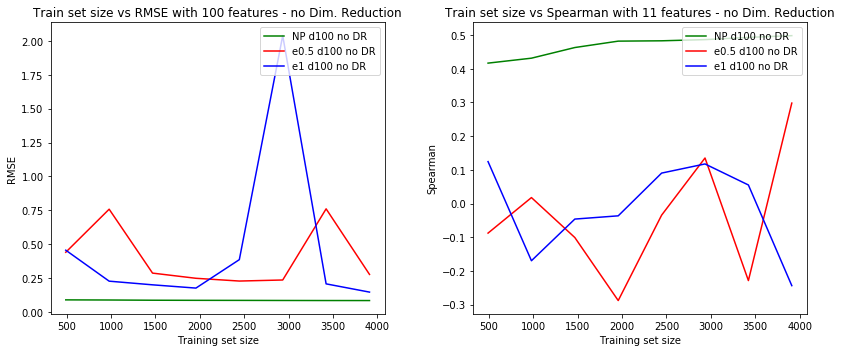

In [16]:
plt.subplot(1,2,1)
plt.rcParams['figure.figsize'] = (12,5)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="solid")
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[1], color="red", ecolor="red", capsize=3, label="e0.5 d100 no DR", ls="solid")
plt.errorbar(ans_withoutDR_e10[0], ans_withoutDR_e10[1], color="blue", ecolor="blue", capsize=3, label="e1 d100 no DR", ls="solid")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction")

plt.subplot(1,2,2)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[6], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="solid")
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[5], color="red", ecolor="red", capsize=3, label="e0.5 d100 no DR", ls="solid")
plt.errorbar(ans_withoutDR_e10[0], ans_withoutDR_e10[5], color="blue", ecolor="blue", capsize=3, label="e1 d100 no DR", ls="solid")
plt.xlabel("Training set size")
plt.ylabel("Spearman")
pylab.legend(loc='upper right')
plt.title("Train set size vs Spearman with 11 features - no Dim. Reduction")
plt.tight_layout()
plt.show()

## Implementing PCA and plotting training set size vs RMSE for different privacy levels with Non-private graph

In [46]:
reduced_d = [2]
plotnum = 1
eps = [5, 10]
rep = 30
pts = 20
x_priv_plots_PCA = np.ones((0, pts))
y_priv_plots_PCA = np.ones((0, pts))
x_pca = X


for i in range(len(reduced_d)):
    d = reduced_d[i]   
    x_pca = getPCA(d, X)
    np.save('drive/My Drive/Colab Notebooks/x_pcawine.npy', x_pca)
    for j in range(len(entries)):
        n = entries[j]
        jump = math.floor(n/pts)
        for eps_idx in range(len(eps)):
            epsilon = eps[eps_idx]
            ans = priv_plotter(x_pca, y, n, d, k, epsilon, jump, 10, 1, 1)
            print("eps")
            
            if epsilon==5:
                ans_PCA_e5_d10 = ans
                np.save('drive/My Drive/Colab Notebooks/ans_PCA_e5_d10wine.npy', ans_PCA_e5_d10)
                
            if epsilon==10:
                ans_PCA_e10_d10 = ans
                np.save('drive/My Drive/Colab Notebooks/ans_PCA_e10_d10wine.npy', ans_PCA_e10_d10)
            

eps
eps


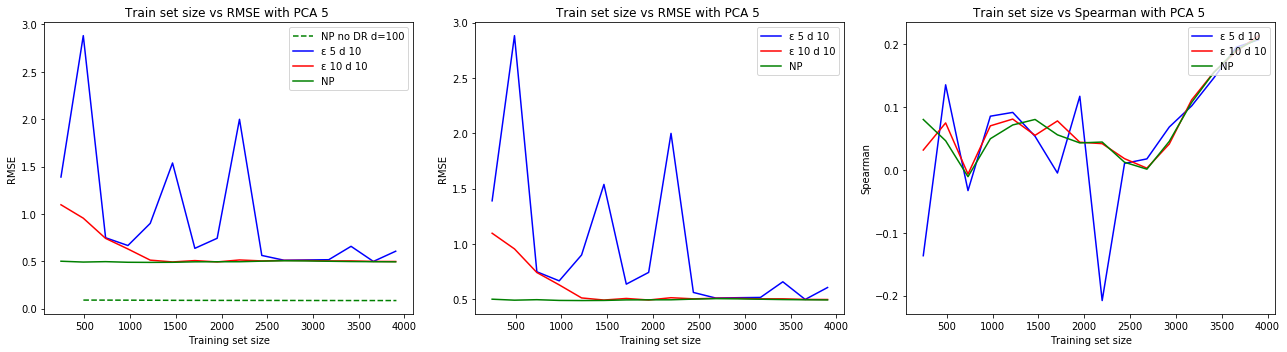

In [47]:
ans_PCA_e5_d10 = np.load('drive/My Drive/Colab Notebooks/ans_PCA_e5_d10wine.npy')
ans_PCA_e10_d10 = np.load('drive/My Drive/Colab Notebooks/ans_PCA_e10_d10wine.npy')

plt.subplot(1,3,1)
plt.rcParams['figure.figsize'] = (18,5)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[3], color="green", ecolor="green", capsize=3, label='NP no DR d=100', ls='dashed')

plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[1], color="blue", ecolor="blue", capsize=3, label='ε 5 d 10')
plt.errorbar(ans_PCA_e10_d10[0], ans_PCA_e10_d10[1], color="red", ecolor="red", capsize=3, label='ε 10 d 10')
plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[3], color="green", ecolor="green", capsize=3, label='NP')
plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with PCA 5 ")

plt.subplot(1,3,3)
plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[5], color="blue", ecolor="blue", capsize=3, label='ε 5 d 10')
plt.errorbar(ans_PCA_e10_d10[0], ans_PCA_e10_d10[5], color="red", ecolor="red", capsize=3, label='ε 10 d 10')
plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[6], color="green", ecolor="green", capsize=3, label='NP')
plt.xlabel("Training set size")
plt.ylabel("Spearman")
pylab.legend(loc='upper right')
plt.title("Train set size vs Spearman with PCA 5 ")


plt.subplot(1,3,2)

plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[1], color="blue", ecolor="blue", capsize=3, label='ε 5 d 10')
plt.errorbar(ans_PCA_e10_d10[0], ans_PCA_e10_d10[1], color="red", ecolor="red", capsize=3, label='ε 10 d 10')
plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[3], color="green", ecolor="green", capsize=3, label='NP')
plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
# plt.ylim(0.18635,0.1870)
plt.title("Train set size vs RMSE with PCA 5 ")


plt.tight_layout()
plt.show()


## ALI

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras.backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Flatten, Reshape, Dropout, Lambda
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from keras.utils import Progbar


# Setting some NN Params
initial_dim = 11
intermediate_dim = 6
latent_dim = 2
epochs = 200
batch_size = 32
final_dim = 3
realData = X
lr = 0.0001

In [0]:
def create_x_generator():
  
  x_input = Input(shape=(latent_dim, ))
  
  # Dropout for Regularization
  x = Dropout(0.2)(x_input)
  x = Dense(intermediate_dim)(x)
  output = Dense(initial_dim)(x)
  
  x_gen_model = Model(x_input, output, name='xGenerator')
#   x_gen_model.summary()
  
  return x_gen_model

def create_z_generator():
  
  z_input = Input(shape=(initial_dim, ))
  
  # Dropout for Regularization
  z = Dropout(0.2)(z_input)
  z = Dense(intermediate_dim)(z)
  output = Dense(latent_dim)(z)
  
  z_gen_model = Model(z_input, output, name='zGenerator')
#   z_gen_model.summary()
  
  return z_gen_model


def create_discriminator():
  
  x_input = Input(shape=(initial_dim, ))
  z_input = Input(shape=(latent_dim, ))
  
  # Dropout for Regularization
  x = Dropout(0.2)(x_input)
  z = Dropout(0.2)(z_input)
  
  x = Dense(10)(x)
  z = Dense(10)(z)
  
  concatenated = Concatenate(axis=-1)([x, z])
  output = Dropout(0.5)(concatenated)
  output = Dense(1)(output)
  
  discriminator_model = Model([x_input, z_input], output, name='discriminator')
#   discriminator_model.summary()
  
  return discriminator_model
  
  
def create_ALIGAN(x_generator, z_generator, discriminator):
#   print("a")
  x_input = Input(shape=(initial_dim, ))
  z_input = Input(shape=(latent_dim, ))
  
  x_gen = x_generator(z_input)
  z_gen = z_generator(x_input)
  
  p = discriminator([x_gen, z_input])
  q = discriminator([x_input, z_gen])
  
  output = Concatenate(axis=-1)([p, q])
  aligan_model = Model([x_input, z_input], output, name='aligan')
  return aligan_model
  

def d_lossfun(y_true, y_pred):
    # Clip is to make sure p and q stays in the particular interval
    p = K.clip(y_pred[:,0], K.epsilon(), 1.0 - K.epsilon())
    q = K.clip(y_pred[:,1], K.epsilon(), 1.0 - K.epsilon())
    return -K.mean(K.log(q) + K.log(1. - p))
  
def g_lossfun(y_true, y_pred):
    # Clip is to make sure p and q stays in the particular interval
    p = K.clip(y_pred[:,0], K.epsilon(), 1.0 - K.epsilon())
    q = K.clip(y_pred[:,1], K.epsilon(), 1.0 - K.epsilon())
    return -K.mean(K.log(1. - q) + K.log(p))
  
def reconstruct_latent_points(x,xgen,zgen):
    z_gen = zgen.predict_on_batch(x)
    return z_gen

def generate_data(xgen):
    num_generate_pts = 100
    z_dim = xgen.input_shape[-1]
    z = np.random.normal(size=(num_generate_pts, latent_dim))
    x_gen = xgen.predict_on_batch(z)
    return x_gen
  

In [74]:
xgen = create_x_generator()
zgen = create_z_generator()
disc = create_discriminator()
opt_d = Adam(lr=lr, beta_1=0.9, beta_2=0.999, decay=0.0)
opt_g = Adam(lr=lr, beta_1=0.9, beta_2=0.999, decay=0.0)

xgen.trainable = False
zgen.trainable = False
disc.trainable = True
gan_d = create_ALIGAN(xgen, zgen, disc)
gan_d.compile(optimizer=opt_d, loss=d_lossfun)
# gan_d.summary()

xgen.trainable = True
zgen.trainable = True
disc.trainable = False
gan_g = create_ALIGAN(xgen, zgen, disc)
gan_g.compile(optimizer=opt_g, loss=g_lossfun)
# gan_g.summary()


# =====================================
# Training Loop
# =====================================
tr_size = math.floor(4*n/5)
num_train = len(realData)
for epoch in range(epochs):
    print('Epochs %d/%d' % (epoch+1, epochs))
    pbar = Progbar(num_train)
    for i in range(0, tr_size, batch_size):
        x = realData[i:i+batch_size]
        z = np.random.normal(size=(len(x), latent_dim))
        # train discriminator
        d_loss = gan_d.train_on_batch([x, z], np.zeros((len(x), 1)))
        # train generators
        g_loss = gan_g.train_on_batch([x, z], np.zeros((len(x), 1)))
        # update progress bar
        pbar.add(len(x), values=[
            ('d_loss', d_loss),
            ('g_loss', g_loss),
        ])



    

Epochs 1/200


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3616/4898 [=====================>........] - ETA: 0s - d_loss: 1.8097 - g_loss: 29.1323

In [76]:
latent_vector = zgen.predict(realData)
print(latent_vector.shape)
jump = math.floor(n/pts)

print("eps")
ans_ALI_e5_d10 = priv_plotter(latent_vector, y, n, 2, k, 5, jump, rep, 1, 1)
np.save('drive/My Drive/Colab Notebooks/ans_ALI_e5_d10wine.npy', ans_ALI_e5_d10)

print("eps")
ans_ALI_e10_d10 = priv_plotter(latent_vector, y, n, 2, k, 10, jump, rep, 1, 1)
np.save('drive/My Drive/Colab Notebooks/ans_ALI_e10_d10wine.npy', ans_ALI_e10_d10)


(4898, 2)
eps
eps


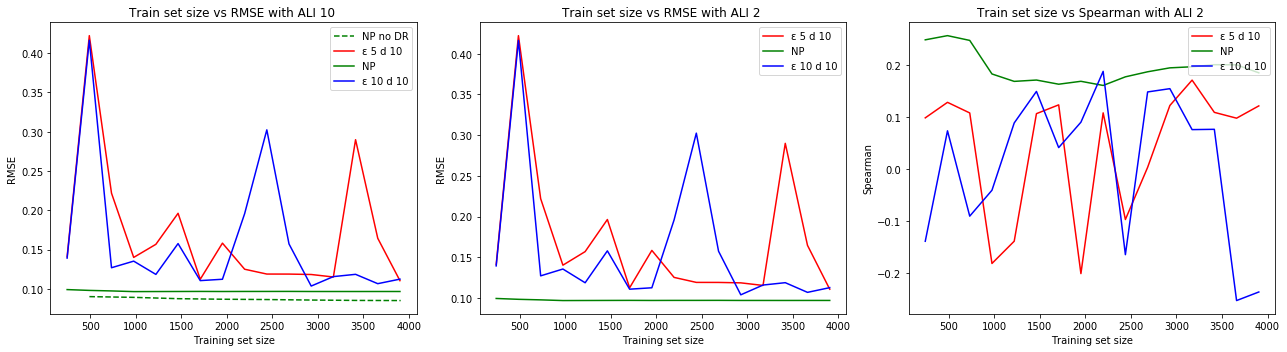

In [77]:
ans_ALI_e5_d10 = np.load('drive/My Drive/Colab Notebooks/ans_ALI_e5_d10wine.npy')
ans_ALI_e10_d10 = np.load('drive/My Drive/Colab Notebooks/ans_ALI_e10_d10wine.npy')


plt.rcParams['figure.figsize'] = (18,5)
plt.subplot(1,3,1)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[3], color="green", ecolor="green", capsize=3, label='NP no DR', ls='dashed')
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[1], color="red", ecolor="red", capsize=3, label='ε 5 d 10')
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[3], color="green", ecolor="green", capsize=3, label='NP')
plt.errorbar(ans_ALI_e10_d10[0], ans_ALI_e10_d10[1], color="blue", ecolor="blue", capsize=3, label='ε 10 d 10')
plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
# plt.ylim(0, 0.24)
plt.title("Train set size vs RMSE with ALI 10 ")

plt.subplot(1,3,2)
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[1], color="red", ecolor="red", capsize=3, label='ε 5 d 10')
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[3], color="green", ecolor="green", capsize=3, label='NP')
plt.errorbar(ans_ALI_e10_d10[0], ans_ALI_e10_d10[1], color="blue", ecolor="blue", capsize=3, label='ε 10 d 10')
plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
# plt.ylim(0.1947,0.1965)
plt.title("Train set size vs RMSE with ALI 2 ")

plt.subplot(1,3,3)
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[5], color="red", ecolor="red", capsize=3, label='ε 5 d 10')
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[6], color="green", ecolor="green", capsize=3, label='NP')
plt.errorbar(ans_ALI_e10_d10[0], ans_ALI_e10_d10[5], color="blue", ecolor="blue", capsize=3, label='ε 10 d 10')
plt.xlabel("Training set size")
plt.ylabel("Spearman")
pylab.legend(loc='upper right')
# plt.ylim(0.2225,0.232)
plt.title("Train set size vs Spearman with ALI 2 ")


plt.tight_layout()
plt.show()

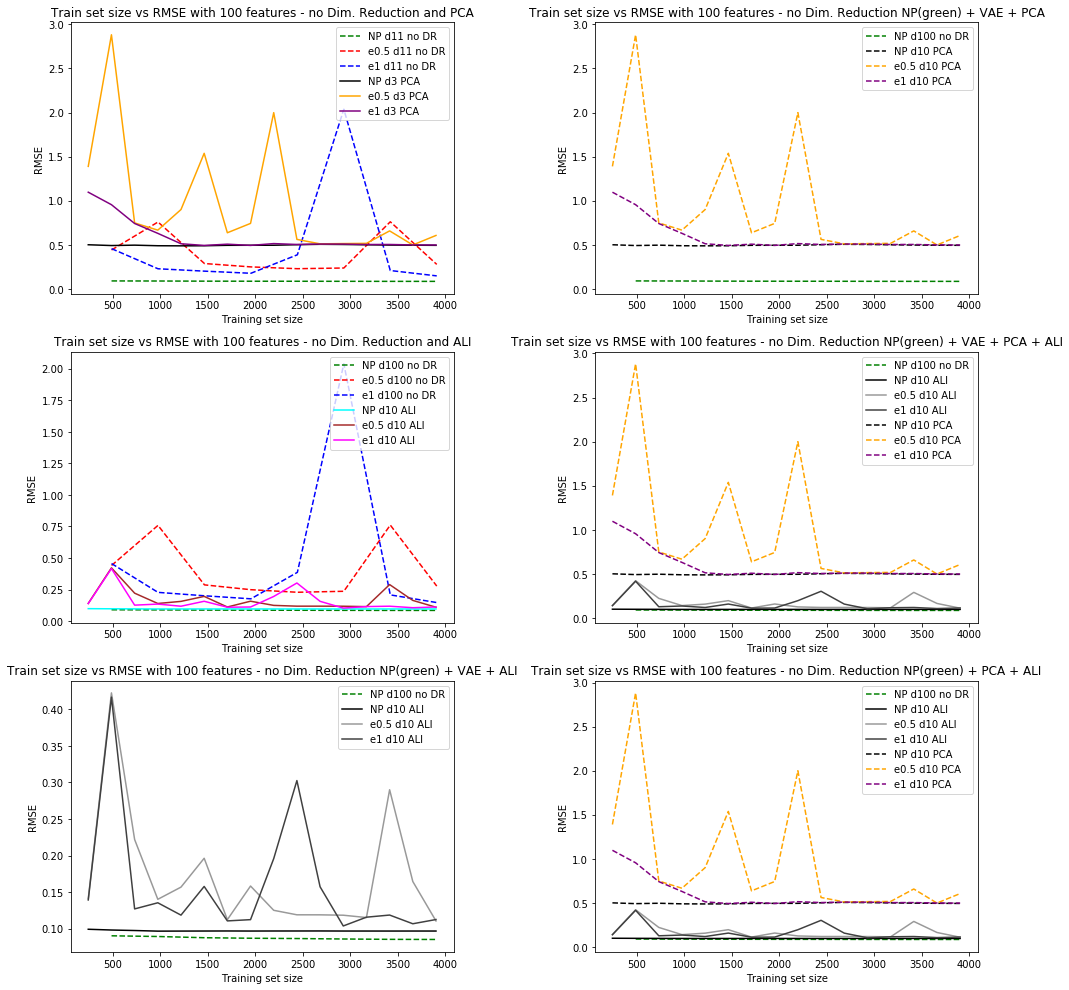

In [78]:
plt.rcParams['figure.figsize'] = (15, 18)

plt.subplot(4,2,1)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[3], color="green", ecolor="green", capsize=3, label="NP d11 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[1], color="red", ecolor="red", capsize=3, label="e0.5 d11 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e10[0], ans_withoutDR_e10[1], color="blue", ecolor="blue", capsize=3, label="e1 d11 no DR", ls="dashed")

plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d3 PCA", ls="solid")
plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[1], color="orange", ecolor="orange", capsize=3, label="e0.5 d3 PCA", ls="solid")
plt.errorbar(ans_PCA_e10_d10[0], ans_PCA_e10_d10[1], color="purple", ecolor="purple", capsize=3, label="e1 d3 PCA", ls="solid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction and PCA")


plt.subplot(4,2,3)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[1], color="red", ecolor="red", capsize=3, label="e0.5 d100 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e10[0], ans_withoutDR_e10[1], color="blue", ecolor="blue", capsize=3, label="e1 d100 no DR", ls="dashed")

plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[3], color="cyan", ecolor="cyan", capsize=3, label="NP d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[1], color="brown", ecolor="brown", capsize=3, label="e0.5 d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e10_d10[0], ans_ALI_e10_d10[1], color="magenta", ecolor="magenta", capsize=3, label="e1 d10 ALI", ls="solid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction and ALI")

plt.subplot(4,2,4)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")

plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[1], color="0.6", ecolor="0.6", capsize=3, label="e0.5 d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e10_d10[0], ans_ALI_e10_d10[1], color="0.25", ecolor="0.25", capsize=3, label="e1 d10 ALI", ls="solid")

plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 PCA", ls="dashed")
plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[1], color="orange", ecolor="orange", capsize=3, label="e0.5 d10 PCA", ls="dashed")
plt.errorbar(ans_PCA_e10_d10[0], ans_PCA_e10_d10[1], color="purple", ecolor="purple", capsize=3, label="e1 d10 PCA", ls="dashed")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction NP(green) + VAE + PCA + ALI")



plt.subplot(4,2,5)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")

plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[1], color="0.6", ecolor="0.6", capsize=3, label="e0.5 d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e10_d10[0], ans_ALI_e10_d10[1], color="0.25", ecolor="0.25", capsize=3, label="e1 d10 ALI", ls="solid")


plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction NP(green) + VAE + ALI")


plt.subplot(4,2,6)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")

plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e5_d10[0], ans_ALI_e5_d10[1], color="0.6", ecolor="0.6", capsize=3, label="e0.5 d10 ALI", ls="solid")
plt.errorbar(ans_ALI_e10_d10[0], ans_ALI_e10_d10[1], color="0.25", ecolor="0.25", capsize=3, label="e1 d10 ALI", ls="solid")

plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 PCA", ls="dashed")
plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[1], color="orange", ecolor="orange", capsize=3, label="e0.5 d10 PCA", ls="dashed")
plt.errorbar(ans_PCA_e10_d10[0], ans_PCA_e10_d10[1], color="purple", ecolor="purple", capsize=3, label="e1 d10 PCA", ls="dashed")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction NP(green) + PCA + ALI")



plt.subplot(4,2,2)
plt.errorbar(ans_withoutDR_e5[0], ans_withoutDR_e5[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")

plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 PCA", ls="dashed")
plt.errorbar(ans_PCA_e5_d10[0], ans_PCA_e5_d10[1], color="orange", ecolor="orange", capsize=3, label="e0.5 d10 PCA", ls="dashed")
plt.errorbar(ans_PCA_e10_d10[0], ans_PCA_e10_d10[1], color="purple", ecolor="purple", capsize=3, label="e1 d10 PCA", ls="dashed")


plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction NP(green) + VAE + PCA")
plt.tight_layout()
plt.show()